In [2]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

In [3]:
import renyi
import utils
from renyi import renyi_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel
from renyi import test_mixture_divergence, renyi_mixture_divergence_stable
from renyi import renyi_mixture_divergence, renyi_sim_divergence, renyi_sim_divergence_stable

In [4]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [5]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size_p = 600
batch_size_q = 512

In [30]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [385]:
alpha = 1
sigma_mult = 0.75

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: renyi_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
                                                 use_avg=False, use_full=False, symmetric=False)

# D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel,
#                                          symmetric=True, use_avg=False)

# for g in g_optimizer.param_groups:
#     g['lr'] = 1e-5

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 21.2320
200 - 1.1176
400 - 0.9974
600 - 0.7477
800 - 0.8767
1000 - 0.6368
1200 - 0.5024
1400 - 0.4060
1600 - 0.3651
1800 - 0.3119
2000 - 0.2518
2200 - 0.3292
2400 - 0.2486
2600 - 0.2138
2800 - 0.1815
3000 - 0.1839
3200 - 0.1876
3400 - 0.1948
3600 - 0.2801
3800 - 0.2886
4000 - 0.1549
4200 - 0.1840
4400 - 0.1476
4600 - 0.1760
4800 - 0.2060


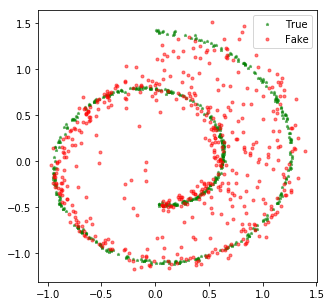

In [34]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='best');

In [354]:
bs1, bs2, n = 100, 80, 10
# bs1, bs2, n = 4, 2, 5

K = torch.rand(n, n).double()
for i in range(n):
    K[i,i] = 1.0
K = (K + K.t()) / 2
log_K = torch.log(K)

# K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=False))
# log_K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=True))

p = torch.rand(bs1, n).double()
p[:, 1] = 0
p = p / p.sum(dim=1, keepdim=True)
q = torch.rand(bs1, n).double()
q[:, 0] = 0
q = q / q.sum(dim=1, keepdim=True)

Y = torch.randn(bs1, n).double() * 2
X = torch.randn(bs2, n).double()

alpha, P1 = 1, False

In [355]:
renyi_sim_divergence(K, p, q, alpha, P1).abs().sum(), renyi_sim_divergence_stable(log_K, p, q, alpha, P1).abs().sum()

(tensor(13.8918, dtype=torch.float64), tensor(13.8918, dtype=torch.float64))

In [17]:
from sinkhorn_pointcloud import sinkhorn_normalized, sinkhorn_loss

In [33]:
emp_probs_p = torch.ones(batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(batch_size_q).cuda()/batch_size_q

epsilon = 0.01
niter = 10
D = lambda x, y: sinkhorn_normalized(x, y, epsilon, emp_probs_p, emp_probs_q, batch_size_p, batch_size_q, niter)

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.0204
200 - 0.0197


KeyboardInterrupt: 